In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import re

In [2]:
import matplotlib.font_manager as fm

font_files = fm.findSystemFonts(fontpaths=['/mnt/c/Windows/Fonts', '/mnt/c/Users/trommer/AppData/Local/Microsoft/Windows/Fonts'], fontext='otf')

for font_file in font_files:
    fm.fontManager.addfont(font_file)

import matplotlib as mpl
#mpl.rcParams['font.family'] = 'Neue Haas Grotesk Text Pro'
# mpl.rcParams['font.family'] = 'Linux Biolinum'
mpl.rcParams['font.family'] = 'CMU Sans Serif'

plt.rcParams['font.size'] = 8
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.axisbelow'] = True

colors = sns.color_palette('Set2')
sns.set_palette('Set2')

In [3]:
def read_results(path):
    with open(path, 'r') as f:
        data = json.load(f)
    benchmarks = data['benchmarks']

    res = []
    for b in benchmarks:
        flat_dict = {**b['params'], **b['stats']}
        res.append(flat_dict)

    df = pd.DataFrame.from_records(res)
    b_name = os.path.basename(path)
    f_name, _ = os.path.splitext(b_name)
    df['filename'] = f_name
    return df

In [16]:
ta = read_results('benchmark_results/221215_conv_layer_torchapprox.json')
tf = read_results('benchmark_results/221215_conv_layer_tfapprox.json')
df = pd.concat([ta, tf], ignore_index=True)
df.loc[df.bench_type.isna(), 'bench_type'] = 'tfapprox'
df.bench_type = df.bench_type.apply(lambda s: s[0] if isinstance(s, list) else s)
df.sort_values(['channels', 'bench_type'], inplace=True, ignore_index=True)
df = df[~(df.bench_type.str.contains('mul12') | df.bench_type.str.contains('mul16'))]
df = df[df.channels > 1].reset_index(drop=True)

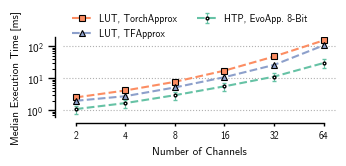

In [21]:
fig = plt.figure(figsize=(3.5,2.0))
ax = fig.add_subplot(111)


# ax.yaxis.set_tick_params(which='minor', size=2, width=0.75)

params = [
    
    ('mul8s', 'HTP, EvoApp. 8-Bit', 'o'),
    ('lut','LUT, TorchApprox', 's'),
    ('tfapprox', 'LUT, TFApprox', '^'),
]
for key, name, marker in params:
    models = df[df.bench_type.str.contains(key)]
    if key == 'mul8s':
        means = models.groupby('channels')['median'].agg('mean')
        stds = models.groupby('channels')['median'].agg('std')
        x = np.unique(models.channels)
        plt.errorbar(x, means.values * 1000, yerr=stds.values * 1000, label=name, capsize = 1.5, linestyle='--', ecolor=colors[0], elinewidth=0.8, markersize=2.0, markerfacecolor='white', marker=marker, markeredgecolor='black', barsabove=False, zorder=3)
        # plt.errorbar(x, means.values * 1000, yerr=stds.values * 1000)
    else:
        plt.plot(models.channels, models['median'] * 1000, label=name, marker=marker, linestyle='--', markersize=5.0, markeredgecolor='black', markeredgewidth=0.8)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Number of Channels')
ax.set_ylabel('Median Execution Time [ms]')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 6))
ax.spines['bottom'].set_position(('outward', 4))
ax.spines['bottom'].set_bounds(2, 64)

ax.set_xticks(np.unique(df.channels))
ax.set_xticklabels(np.unique(df.channels), fontsize=7)
ax.xaxis.set_tick_params(which='major', size=2, width=1)
ax.xaxis.set_tick_params(which='minor', bottom=False)

ax.yaxis.set_tick_params(which='major', size=5, width=1, direction='out')
ax.yaxis.set_tick_params(which='minor', size=2, width=0.75, direction='out')
ax.yaxis.grid(linestyle='dotted')
#ax.set_ylim(2e-1, 1e3)
# ax.set_xlim(1.4,70)

ax.legend(ncol=2, frameon=False, loc='upper left', bbox_to_anchor=(0, 1.40), fontsize=7)
plt.tight_layout()
plt.savefig('conv2d_benchmark.pdf', bbox_inches='tight')
plt.show()
    

In [6]:
from scipy.stats import gmean
vals = df[df.bench_type == 'tfapprox']['median'] / df[df.bench_type.str.contains('mul8')].groupby('channels')['median'].agg('mean').values
vals

17     1.814306
35     1.644143
53     1.746924
71     1.926632
89     2.316555
107    3.552253
Name: median, dtype: float64

In [7]:
pretty_names = {
    'alexnet' : 'AlexNet',
    'effcientnet_b0' : 'EfficientNetB0',
    'mobilenet_v2' : 'MobileNetV2',
    'resnet18' : 'ResNet18',
    'resnet50' : 'ResNet50',
    'vgg16' : 'VGG16',
}
df = read_results('benchmark_results/221205_networks.json')
df.loc[df.bench_type.isna(), 'bench_type'] = 'adaPT'
df.bench_type = df.bench_type.apply(lambda s: s[0] if isinstance(s, list) else s)
df = df.loc[~df.bench_type.str.contains("accurate")]
df.bench_architecture = df.bench_architecture.map(pretty_names)
df.sort_values(['bench_architecture', 'bench_type'], inplace=True, ignore_index=True)

In [8]:
print(gmean(df[df.bench_type == 'adaPT']['median'] / df[df.bench_type.str.contains('lut')].groupby('bench_architecture')['median'].agg('mean').values))
print(gmean(df[df.bench_type == 'adaPT']['median'] / df[df.bench_type.str.contains('mul8s')].groupby('bench_architecture')['median'].agg('mean').values))
print(gmean(df[df.bench_type == 'lut']['median'] / df[df.bench_type.str.contains('mul8s')].groupby('bench_architecture')['median'].agg('mean').values))
print((df[df.bench_type == 'lut']['median'] / df[df.bench_type.str.contains('baseline')].groupby('bench_architecture')['median'].agg('mean').values))

35.699849129724136
96.42065462102792
2.7008700868919604
2       9.720705
41      1.932220
80      2.000238
119     7.303726
158     5.498940
197    16.663679
Name: median, dtype: float64


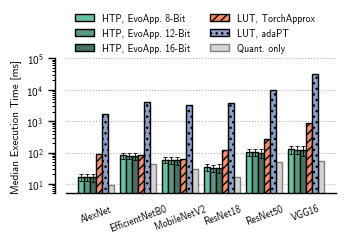

In [9]:
params = [
    # ('mul8s_1L2D', 'HTP Model 1L2D', '///'),
    ('mul8s', 'HTP, EvoApp. 8-Bit', '\\\\\\\\', 0),
    ('mul12s', 'HTP, EvoApp. 12-Bit', '////', 1),
    ('mul16s', 'HTP, EvoApp. 16-Bit', 'xxxx', 2),
    ('lut', 'LUT, TorchApprox', '////', 1),
    ('adaPT', 'LUT, adaPT', '...', 2),
    ('baseline', 'Quant. only', None, 3),
]

width = 0.85/len(params)

fig = plt.figure(figsize=(3.5,2.8))
ax = fig.add_subplot(111)
colors = sns.color_palette('Set2')

for i, (key, label, hatch, c_idx) in enumerate(params):
    ans = df[df.bench_type.str.contains(key)]
    x = np.arange(len(np.unique(ans.bench_architecture))) + i*width
    if key == 'baseline':
        ax.bar(x, height=ans['median'].values * 1000, width=width, align='edge', edgecolor='grey', color = 'lightgrey', label=label, zorder=1)
    elif 'mul' in key:
        palette = sns.dark_palette(colors[0], 5, reverse=True)
        means = ans.groupby('bench_architecture')['median'].agg('mean')
        stds = ans.groupby('bench_architecture')['median'].agg('std')
        ax.bar(x, height=means.values * 1000, yerr=stds.values * 1000, capsize=1.2, error_kw = {'lw':0.6, 'mew': 0.6}, width=width, align='edge', edgecolor='black', color = palette[c_idx], label=label, zorder=2)
    else:
        ax.bar(x, height=ans['median'].values * 1000, width=width, align='edge', edgecolor='black', color = colors[c_idx], hatch=hatch, label=label, zorder=2)

labels = np.unique(df.bench_architecture)
ax.xaxis.set_ticks(np.arange(len(labels)) + len(params)/2 * width, labels, rotation=20, size=7)
ax.xaxis.set_tick_params(bottom=False)
# ax.set_xlim(-0.4, len(np.unique(df.bench_architecture))+0.2)

ax.set_yscale('log')
ax.set_ylabel('Median Execution Time [ms]')
ax.set_ylim(5, 1e5)
ax.yaxis.set_tick_params(which='major', size=5, width=1, direction='out')
ax.yaxis.set_tick_params(which='minor', size=2, width=0.75, direction='out')
ax.yaxis.grid(which='major', linestyle='dotted')

ax.spines['left'].set_position(('outward', 8))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(ncol=2, frameon=False, loc='upper left', bbox_to_anchor=(0, 1.40), fontsize=7)

plt.tight_layout()
plt.savefig('network_benchmark.pdf', bbox_inches='tight')
plt.show() 

In [10]:
def report_accuracy(path, target_metric):
    df = pd.read_csv(path).loc[:,['Duration', 'Name', 'epochs',target_metric]]
    df = df.drop(df.index[df.Name.str.contains('QAT Model') | df.Name.str.contains('Baseline Model')])

    df.loc[df.Name.str.contains('Noise'),'type'] = 'noise'
    df.loc[df.Name.str.contains('Behavioral'),'type'] = 'behavioral'
    df.loc[df.Name.str.contains('Baseline'),'type'] = 'baseline'
    df.loc[df.Name.str.contains('HTP'),'type'] = 'htp'


    def time_to_float(s: str) -> float:
        t = float(re.findall(r'\d*.\d{1,2}', s)[0])
        if 'min' in s:
            t *= 60
        return t

    def mul_name(s: str) -> str:
        return re.findall(r'mul8s_[\w\d]{4}', s)[0]
        
    df.Duration = df.Duration.map(time_to_float)
    df['Multiplier'] = df.Name.map(mul_name)

    for m in np.unique(df.Multiplier):
        bl = df.loc[(df.Multiplier == m) & (df.type=='behavioral'), target_metric].values[0]
        df.loc[df.Multiplier == m, 'Deviation'] = df.loc[df.Multiplier == m, target_metric] - bl
    df.Deviation = df.Deviation.abs()

    def print_result(df: pd.DataFrame, key: str, scale=1.0):
        mean = (df.groupby('type')[key].agg('mean') * scale).round(2)
        std = (df.groupby('type')[key].agg('std') * scale).round(2)

        print("\n" + key.upper())
        for m, s, l in zip(mean, std, mean.index):
            print(f"{l}: {m} $\pm$ {s}")
    
    
    print_result(df, target_metric, 100.0)
    print_result(df, 'Duration')
    print_result(df, 'Deviation', 100.0)

In [11]:
report_accuracy('accuracy_results/230105_accuracy_lenet5_mnist.csv', 'test_acc_top1')


TEST_ACC_TOP1
baseline: 90.34 $\pm$ 24.86
behavioral: 98.87 $\pm$ 1.13
htp: 98.86 $\pm$ 1.15
noise: 92.26 $\pm$ 24.72

DURATION
baseline: 15.31 $\pm$ 0.3
behavioral: 19.08 $\pm$ 0.28
htp: 15.92 $\pm$ 0.46
noise: 15.85 $\pm$ 0.33

DEVIATION
baseline: 8.54 $\pm$ 23.77
behavioral: 0.0 $\pm$ 0.0
htp: 0.01 $\pm$ 0.02
noise: 6.62 $\pm$ 23.58


In [12]:
report_accuracy('accuracy_results/230105_accuracy_resnet8_cifar.csv', 'test_acc_top1')


TEST_ACC_TOP1
baseline: 67.15 $\pm$ 29.06
behavioral: 79.47 $\pm$ 14.04
htp: 79.27 $\pm$ 14.04
noise: 72.1 $\pm$ 26.54

DURATION
baseline: 36.02 $\pm$ 1.14
behavioral: 59.21 $\pm$ 0.9
htp: 39.65 $\pm$ 2.27
noise: 39.74 $\pm$ 1.25

DEVIATION
baseline: 12.36 $\pm$ 20.1
behavioral: 0.0 $\pm$ 0.0
htp: 0.31 $\pm$ 0.61
noise: 7.43 $\pm$ 15.2


In [13]:
report_accuracy('accuracy_results/230109_accuracy_vgg16_tinyimagenet.csv', 'test_acc_top1')


TEST_ACC_TOP1
baseline: 56.8 $\pm$ 17.27
behavioral: 57.47 $\pm$ 17.21
htp: 57.39 $\pm$ 17.18
noise: 56.73 $\pm$ 17.26

DURATION
baseline: 221.54 $\pm$ 5.17
behavioral: 978.46 $\pm$ 6.69
htp: 258.46 $\pm$ 20.41
noise: 225.69 $\pm$ 5.22

DEVIATION
baseline: 0.73 $\pm$ 1.94
behavioral: 0.0 $\pm$ 0.0
htp: 0.08 $\pm$ 0.26
noise: 0.78 $\pm$ 1.93
